In [1]:
import numpy as np
#import jax.numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from ipywidgets import interactive, IntSlider
from lmfit import minimize, Parameters
import itertools
import warnings

CHECK DIAGONAL COEF, POLYNOMIAL FEATURES

In [2]:
plt.style.use('ggplot')

In [24]:
OLCI_WBANDS = np.array([400,412.5,442.5,490,510,560,620,665,673.75,681.25,708.75])
HSI_WBANDS = np.arange(400, 711, 5)
WBANDS = OLCI_WBANDS

In [25]:
def interpolate_to_wavebands(data, wavelength, index='wavelength'):
    '''
    interpolates SIOPs to OLCI/MERIS wavebands
    '''
    data.reset_index(inplace=True)
    # add OLCI/MERIS wavebands to phytop SIOP wavelengths
    wband_merge = np.unique(sorted(np.append(data[index], wavelength)))
    
    data.set_index(index, inplace=True)
    data = data.reindex(wband_merge)\
        .astype(float)\
        .interpolate(method='slinear', fill_value=0, limit_direction='both')\
        .reindex(wavelength)
    
    return data

In [26]:
# load phytoplankton basis vector
a_phyto_base_full = pd.read_csv('../hydropt/data/phyto_siop.csv', sep=';', index_col=0)
# interpolate to OLCI wavebands
a_phyto_base = interpolate_to_wavebands(data=a_phyto_base_full, wavelength=WBANDS)

In [27]:
class IOP_model:
    def __init__(self):
        self._wavebands = None
        self.iop_model = None
    
    def set_iop(self, wavebands, **kwargs):
        if self.check_wavelen(wavebands, **kwargs):
            self._wavebands = wavebands
            self.iop_model = {k: v for (k,v) in kwargs.items()}
    
    def get_iop(self, **kwargs):
        iops = []
        for k, value in kwargs.items():
            iops.append([self.iop_model.get(k)(value)[0]()])
        
        iops = np.vstack(iops)
        
        return iops
   
    def get_gradient(self, **kwargs):
        grads = []
        for k, value in kwargs.items():
            grads.append([self.iop_model.get(k)(value)[1]()])
        
        grads = np.vstack(grads)
        
        return grads
    
    def sum_iop(self, **kwargs):
        iops = self.get_iop(**kwargs).sum(axis=0)
        
        return iops
    
    def plot(self, **kwargs):
        n = len(kwargs)
        fig, axs = plt.subplots(1,n, figsize=(14,4))
        # clean-up loop code
        for (k,v), ax in zip(kwargs.items(), axs):
            ax2 = ax.twinx()
            ax.plot(self._wavebands, self.get_iop(**{k:v})[0][0])
            ax.set_xlabel('wavelength')
            ax.set_ylabel('absorption')
            ax.set_title(k)
            ax2.plot(self._wavebands, self.get_iop(**{k:v})[0][1], color='blue')
            ax2.set_ylabel('backscatter')
        plt.tight_layout()
        #return fig
        
    @staticmethod
    def check_wavelen(wavebands, **kwargs):
        models = [i for i in kwargs.values()]
        # check dimensions of models; skip gradients for now
        dims = [i(1)[0]().shape[1] for i in models]
        # check if all dimension match
        if len(set(dims)) != 1:
            raise ValueError('length of IOP vectors do not match')
        elif dims[0] != len(wavebands):
            raise ValueError('number of wavebands do not match with length of IOP vectors')
        
        return True

In [45]:
class Hydropt:
    def __init__(self, iop_model):
        self.iop_model = iop_model
        self._weights = np.ones([len(iop_model._wavebands), 1])
        self.model_coef = None
        self.model_powers = None
        self.set_model_coef()
        
    def set_model_coef(self):
        model_coef = pd.read_csv('../../hydropt_4_sent3/data/processed/model_coefficients/OLCI_polynom_05.csv', index_col = 0)
        #model_coef = pd.read_csv('../hydropt/data/OLCI_polynom_04.csv', index_col = 0)
        # check if wavebands match
        if np.array_equal(model_coef.index, self.iop_model._wavebands):
            self.model_coef = model_coef
            self.model_powers = PolynomialFeatures(degree=5).fit([[1,1]]).powers_
        else:
            raise ValueError('wavebands do not match number of model coefficients')
            
    def hydrolight_polynom(self, x): #, degree=5):
        '''
        Forward model using polynomial fit to Hydrolight simulations

        x[0]: total absorption at wavelength i
        x[1]: total backscatter at wavelength i

        returns Rrs
        '''
        # log absorption, backscatter
        x_log = np.log(x)
        # get polynomial features
        #ft = PolynomialFeatures(degree=degree).fit_transform(x_log.T)
        ft = self._polynomial_features(x_log.T)
        # get polynomial coefficients
        c = self.model_coef.values
        # calculate log(Rrs)
        log_rrs = np.dot(c, ft.T).diagonal()
        # calculate Rrs
        rrs = np.exp(log_rrs)

        return rrs
    
    def _polynomial_features(self, x):
        x = x.T
        f = np.array([(x[0]**i)*(x[1]**j) for (i,j) in self.model_powers]).T
    
        return f
    
    def forward(self, **kwargs):
        # calculate total absorption/backscatter
        iop = self.iop_model.sum_iop(**kwargs)
        
        return self.hydrolight_polynom(iop)
    
    def gradient(self, x):
        '''
        Jacobian at [x] of the remote-sensing reflectance (Rrs),
        using the Hydrolight polynomial as forward model, w.r.t concentration of constituents

        x - instance of lmfit.Parameters
        '''
        if isinstance(x, Parameters):
            # params to dict
            x = dict(x.valuesdict())
            
        def grad_2d_polynomial(x):
            '''
            gradient of 2 variable polynomial

            x: points at wich to evaluate the derivative; a nx2 array were n is number of wavebands
            '''
            c = self.model_coef.values
            p = self.model_powers
            # check if dimensions match of polynomial and x
            if c.shape[0] is not x.shape[0]:
                warnings.warn('matrix dimensions of x and c do not match!')
            # get derivative terms of polynomial features
            d_x1 = lambda x, p: p[0]*x[0]**(float(p[0]-1))*x[1]**p[1]
            d_x2 = lambda x, p: p[1]*x[1]**(float(p[1]-1))*x[0]**p[0]
            # evaluate terms at [x]
            ft = np.array([[d_x1(x,p), d_x2(x,p)] for (x,p) in zip(itertools.cycle([x.T]), p)])
            # dot derivative matrix with polynomial coefficients and get diagonal
            dx = np.array([np.dot(c,ft[:,0,:]).diagonal(),
                           np.dot(c,ft[:,1,:]).diagonal()])

            return dx
        
        # calculate total IOPs
        iop = self.iop_model.sum_iop(**x)
        # calculate Rrs
        rrs = self.forward(**x)
        # (dln(a)/da) * (dRrs/dln(Rrs)) = Rrs/a
        # (dln(b)/db) * (dRrs/dln(Rrs)) = Rrs/b
        # do element-wise multiplication
        grad_log_iops = np.array([rrs/iop[0],rrs/iop[1]]) * self.iop_model.get_gradient(**x)
        # evaluate jacobian of hydrolight polynomial at x
        grad_polynom = grad_2d_polynomial(np.log(iop.T))
        # initialize empty jacobian matrix
        jac = np.empty([grad_polynom.shape[1], grad_log_iops.shape[0]])  
        for c, (i,j) in enumerate(zip(grad_polynom.T, grad_log_iops.T)):
            jac[c] = np.dot(i,j)
        # do element-wise multiplication of jacobian with weights matrix
        jac = jac*self._weights
        
        return jac

In [46]:
def polynom(x, deg):
    x = x.T
    powers = PolynomialFeatures(degree=deg).fit([[1,1]]).powers_
    f = np.array([(x[0]**i)*(x[1]**j) for (i,j) in powers]).T
    
    return f

In [47]:
def nap(*args, wb):
    '''
    IOP model for NAP
    '''
    # vectorized
    def iop(spm=args[0]):
        return spm*np.array([(.041*.75*np.exp(-.0123*(wb-443))), .014*0.57*(550/wb)])
    
    def gradient():
        d_a = .03075*np.exp(-.0123*(wb-443))
        d_b = .014*0.57*(550/wb)
        
        return np.array([d_a, d_b])
    
    return iop, gradient

In [48]:
def cdom(*args, wb):
    '''
    IOP model for CDOM
    '''
    def iop(a_440=args[0]):
        return np.array([a_440*np.exp(-0.017*(wb-440)), np.zeros(len(wb))])
    
    def gradient():
        '''
        Gradient of CDOM IOP model
        ''' 
        d_a = np.exp(-.017*(wb-440))
        d_b = np.zeros(len(d_a))
        
        return np.array([d_a, d_b])
    
    return iop, gradient

In [49]:
def phyto(*args):
    '''
    IOP model for phytoplankton w. 
    packaging effect - according to Prieur&Sathyenadrath (1981)
    basis vector - according to Ciotti&Cullen 2002
    '''   
    def iop(chl=args[0]):
        # calculate absorption
        a = 0.06*np.power(chl,.65)*a_phyto_base.absorption.values
        # calculate backscatter according to 0.1-tadzio-IOP_backscatter
        # notebook in hydropt-4-sent3
        b = np.repeat(.014*0.18*np.power(chl,.471), len(a))
        
        return np.array([a, b])
    
    def gradient():
        return np.zeros([2,63])
    
    return iop, gradient

In [50]:
def waveband_wrapper(f, wb):
    def inner(*args, **kwargs):
        kwargs['wb'] = wb
        return f(*args, **kwargs)
    return inner

In [51]:
class ThreeCompModel(IOP_model):
    def __init__(self):
        self.set_iop(OLCI_WBANDS, 
                     nap=waveband_wrapper(nap, wb=OLCI_WBANDS),
                     cdom=waveband_wrapper(cdom, wb=OLCI_WBANDS),
                     chl=phyto)

In [52]:
params_c1 = Parameters()
params_c1.add('cdom', value=2.0, min=1E-9, max=9)
params_c1.add('nap', value=2.0, min=1E-9, max=9)
#params_c1.add('chl', value=1.0, min=1E-9, max=100)

In [53]:
a = ThreeCompModel()

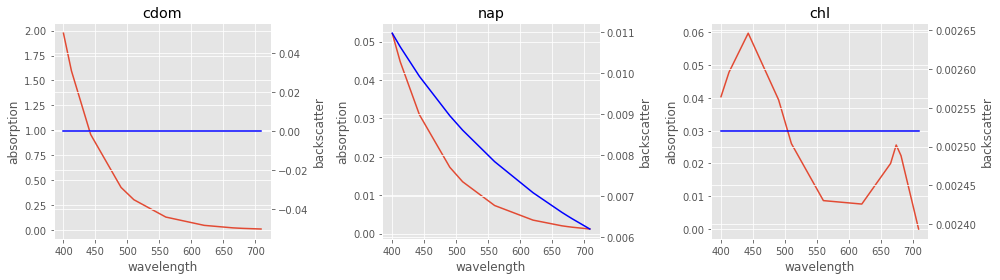

In [54]:
a.plot(cdom=1, nap=1, chl=1)

In [55]:
ps1 = Hydropt(a)

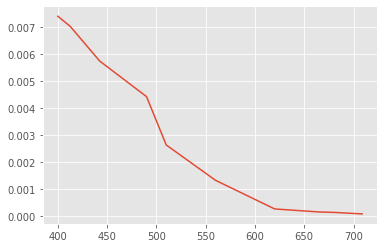

In [56]:
plt.plot(WBANDS, ps1.forward(chl=.1, nap=1E-2, cdom=1E-2))

In [58]:
ps1.forward(chl=.1, nap=100, cdom=1E-1)

array([0.01053044, 0.01209638, 0.0167674 , 0.02723331, 0.0325588 ,
       0.04834353, 0.05407524, 0.051039  , 0.05068929, 0.04980596,
       0.03605316])

In [18]:
from jax import grad, jacfwd, jacrev
import numpy as np
x_1 = {'cdom': 1E-3, 'nap': 1E-2}
p1 = Parameters()
p1.add('cdom', value=x_1['cdom'], min=1E-9, max=1E9)
p1.add('nap', value=x_1['nap'], min=1E-9, max=1E9)
a = ps1.gradient(p1)
import jax.numpy as np
f_x = lambda x: ps1.forward(**x)
b = jacfwd(f_x)(x_1)
print(a[:,0]/b['cdom'])
print('\n')
print(a[:,1]/b['nap'])

/Users/tadzio/anaconda3/envs/hydropt-4-sent3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


[0.9999998  0.9999997  0.9999987  1.0000005  1.0000008  0.99999714
 0.99999946 1.0001037  0.99997544 0.99999195 1.0000001 ]


[0.99999994 0.9999992  0.9999986  0.9999996  1.0000021  0.99999666
 1.0000001  0.9999986  1.0000118  1.0000045  1.000002  ]


In [40]:
g_x = lambda x: ps1.hydrolight_polynom(x)
jacfwd(ps1.hydrolight_polynom)(np.ones([2,63]).T).shape

(2, 63, 2)

## validate Hydropt class
load PACE hydrolight simulations and compare to Hydropt forward model

In [14]:
pace_hl = pd.read_csv('/Users/tadzio/Documents/code_repo/hydropt_4_sent3/data/interim/RRS_NADIR_PACE_acoef_bbcoef.csv',
                      index_col=['CDOM', 'NAP', 'Chl'])

In [15]:
def plot_rrs(x):
    value = pace_hl.index.unique()[x]
    rrs_hl = pace_hl.loc[(value[0], value[1], value[2]), 'rrs'].values
    rrs_hydr = ps1.forward(cdom=value[0], nap=value[1], chl=value[2])
    plt.plot(HSI_WBANDS, rrs_hl, label='hl')
    plt.plot(HSI_WBANDS, rrs_hydr, label='hydropt')
    plt.legend()

In [16]:
def iplot_rrs():
    iplot = interactive(plot_rrs, x=IntSlider(value=0, min=0, max=999))
    output = iplot.children[-1]
    output.layout.height = '300px'
    return iplot

In [17]:
iplot_rrs()

interactive(children=(IntSlider(value=0, description='x', max=999), Output(layout=Layout(height='300px'))), _d…